In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# That's an impressive list of imports.
import numpy as np

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from PIL import Image

import glob
from scipy.misc import imread
from skimage import util
import pandas as pd


import cv2

In [3]:
imagesNIR = sorted(glob.glob('../Imgs/LayersNIR/*.png'))
imagesMAP = sorted(glob.glob('../Imgs/LayersMAP/*.png'))

(-0.5, 808.5, 529.5, -0.5)

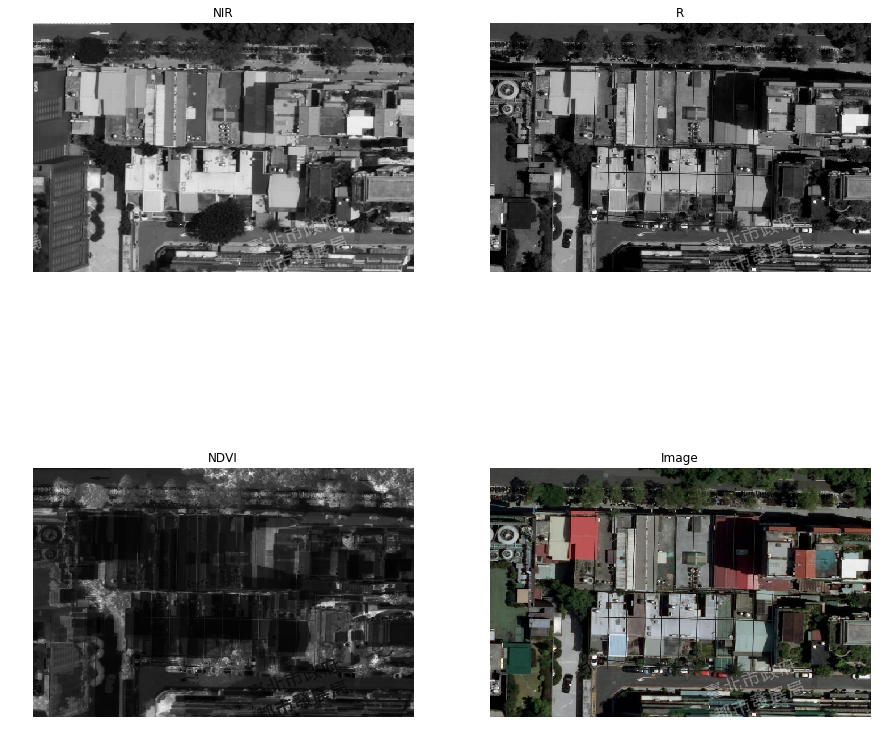

In [34]:
idx = np.random.randint(0, len(imagesNIR))

imgnir, imgmap = imread(imagesNIR[idx], mode='RGB'), imread(imagesMAP[idx], mode='RGB')
invnir2 = util.invert(imgnir)[:,:,0].astype('float32') / 255.0
invnir = imgnir[:,:,0].astype('float32') / 255.0
red = imgmap[:,:,0].astype('float32') / 255.0

NDVI = np.divide(invnir2 - red, invnir + red + np.finfo(float).eps)

nmin, nmax = invnir.min(), invnir.max()
rmin, rmax = red.min(), red.max()

invnir = (invnir - nmin) / (nmax-nmin)
red = (red - rmin) / (rmax - rmin)

invnir = np.clip(invnir, 0, 1)
red = np.clip(red, 0, 1)

dred = darkmap(red)
dnir = darkmap(invnir)

plt.figure(figsize=(15,15))

plt.subplot(2, 2, 1)
plt.imshow(invnir, cmap='gray')
plt.title('NIR')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(imgmap[:,:,0], cmap='gray')
plt.title('R')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(NDVI, cmap='gray')
plt.title('NDVI')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(imgmap, cmap='gray')
plt.title('Image')
plt.axis('off')

def darkmap(channel):
    c = channel ** (1/2.2)
    c = 1.0 / (1.0 + np.exp(-14 * ((1-c)-0.5)))
    return c

dmap = dred * dnir
dmap[dmap > 0.2] = 1.0
dmap[dmap <= 0.2] = 0.0
plt.imshow(dmap, cmap='gray')
plt.axis('off')

0.42735732

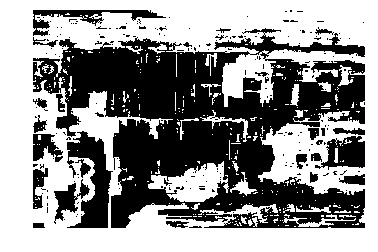

In [38]:
mask2 = np.zeros_like(NDVI)
mask2[np.where((NDVI > 0.6) | (NDVI < -0.6))] = 1.0
plt.imshow(mask2, cmap='gray')
plt.axis('off')
mask2.mean()

0.24061384891666859

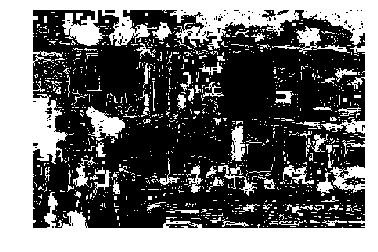

In [39]:
hsv = cv2.cvtColor(imgmap, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, np.array([40, 0, 0]), np.array([70, 255, 255]))

plt.imshow(mask, cmap='gray')
plt.axis('off')
(mask ).mean()/ 255.0

(-0.5, 9.5, 0.5, -0.5)

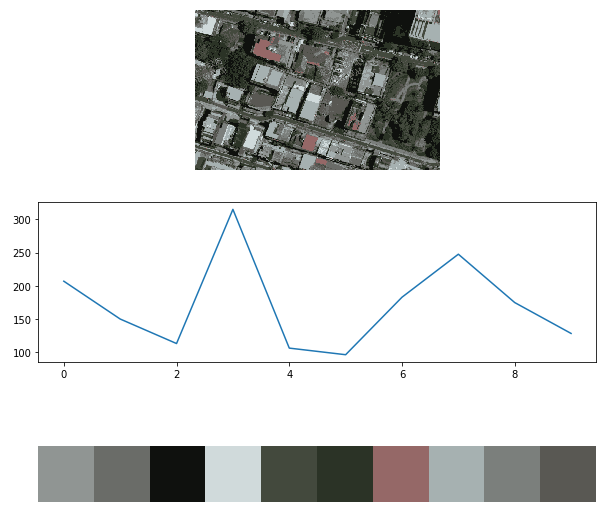

In [109]:
def colDist(c1, c2):
    return np.sqrt(np.square(c1 - c2).sum(axis=1))

green = np.array([[0,128,0]])

Z = imgmap.reshape((-1,3)).astype(np.float32)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((imgmap.shape))

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(res2)
plt.axis('off')
plt.subplot(3, 1, 2)
plt.plot(colDist(center, green))
plt.subplot(3, 1, 3)
plt.imshow(center[None,:,:])
plt.axis('off')